In [3]:
import numpy as np
from scipy.constants import h, c, k
from scipy.integrate import quad
from scipy.interpolate import interp1d
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import os


In [4]:
# === SETTINGS ===
date_str = "20250702" # Date in YYYYMMDD format
ID = "A3"             # Station ID
action_number = "17"  # 17 for Halobates

from pathlib import Path

# === File Paths ===

dir_path = Path.cwd()  # current working directory
print("Current working directory:", dir_path)

# Data directory (assuming it's a sibling folder)
data_dir = dir_path.parent / "data"

# Output path for the raw SST temperature
out_dir = dir_path / "raw"
sst_output_file = out_dir / f"{date_str}_{ID}_{action_number}_IR_SST.csv"

# Water and sky input files
water_file = data_dir / f"{date_str}_{ID}_{action_number}_IR_Water.csv"
sky_file = data_dir / f"{date_str}_{ID}_{action_number}_IR_Sky.csv"

# Output path for the averaged SST temperature
out_dir_avg = dir_path / "1min"
sst_avg_file = out_dir_avg / f"{date_str}_{ID}_{action_number}_IR_SST_1min.csv"

# === Debug output (optional) ===
print("Data directory:", data_dir)
print("Water file:", water_file)
print("Sky file:", sky_file)
print("Raw SST output file:", sst_output_file)
print("Averaged SST output file:", sst_avg_file)



Current working directory: c:\Users\ludog\Nextcloud\CLEWS\work\METEOR\IR Camera\github\Infrared_cameras\postproc
Data directory: c:\Users\ludog\Nextcloud\CLEWS\work\METEOR\IR Camera\github\Infrared_cameras\data
Water file: c:\Users\ludog\Nextcloud\CLEWS\work\METEOR\IR Camera\github\Infrared_cameras\data\20250702_A3_17_IR_Water.csv
Sky file: c:\Users\ludog\Nextcloud\CLEWS\work\METEOR\IR Camera\github\Infrared_cameras\data\20250702_A3_17_IR_Sky.csv
Raw SST output file: c:\Users\ludog\Nextcloud\CLEWS\work\METEOR\IR Camera\github\Infrared_cameras\postproc\raw\20250702_A3_17_IR_SST.csv
Averaged SST output file: c:\Users\ludog\Nextcloud\CLEWS\work\METEOR\IR Camera\github\Infrared_cameras\postproc\1min\20250702_A3_17_IR_SST_1min.csv


In [5]:
# === Define constants ===
lambda_min = 8     # micrometers
lambda_max = 14    # micrometers
emissivity = 0.98  # assumed emissivity of sea surface CHECK CHECK CHECK


# === Define temperature range for lookup tables ===
T_min = 280 # Kelvin
T_max = 310 # Kelvin
n_values = (T_max - T_min) * 1000 # 0.001 K steps

### Define functions and create lookups tables

In [6]:
# === Planck function ===
def planck_lambda(T, lam):
    """Spectral radiance [W/m²/sr/μm] at temperature T [K] and wavelength λ [μm]"""
    lam_m = lam * 1e-6  # convert μm to meters
    return (2*h*c**2 / lam_m**5) / (np.exp(h*c / (lam_m * k * T)) - 1)

# === Convert spectral radiance to band-integrated radiance ===
def band_integrated_radiance(T, lam1=lambda_min, lam2=lambda_max):
    """Band-integrated Planck radiance over [λ1, λ2] for temperature T"""
    result, _ = quad(lambda l: planck_lambda(T, l), lam1, lam2)
    return result

In [7]:
# === Step 1:Generate lookup table of temperature-band intergated radiance values ===
T_range = np.linspace(T_min, T_max + 1, n_values)  # Kelvin
radiance_lookup = np.array([band_integrated_radiance(T) for T in T_range])

# Interpolation function to invert Planck's law
radiance_to_temp = interp1d(radiance_lookup, T_range, bounds_error=False, fill_value="extrapolate")

### Load and prepare the datasets

In [27]:
# === Load water and sky data ===
df_water = pd.read_csv(water_file, sep=";", decimal=",")
df_sky = pd.read_csv(sky_file, sep=";", decimal=",")

# Remove white spaces from the columns titles
df_water.columns = df_water.columns.str.strip() 
df_sky.columns = df_sky.columns.str.strip()

In [28]:
# Sometimes the data is not read correctly so we have to force that the Target(°C) column is a float
# Remove all spaces (including non-breaking) and convert
df_water['Target(°C)'] = (
    df_water['Target(°C)']
    .astype(str)
    .str.replace('\u202f', '')  # Remove narrow no-break space
    .str.replace(' ', '')       # Remove regular spaces
    .str.replace(',', '.')
    .astype(float)
)

# Remove all spaces (including non-breaking) and convert
df_sky['Target(°C)'] = (
    df_sky['Target(°C)']
    .astype(str)
    .str.replace('\u202f', '')  # Remove narrow no-break space
    .str.replace(' ', '')       # Remove regular spaces
    .str.replace(',', '.')
    .astype(float)
)

print("Removed blank spaces in the datasets and converted Target(°C) column to float.")

Removed blank spaces in the datasets and converted Target(°C) column to float.


In [29]:
# === Parse datetime ===
df_water['Time'] = pd.to_datetime(df_water['Date'], format='%b %d %Y %I:%M:%S %p').dt.round("1s")
df_sky['Time']   = pd.to_datetime(df_sky['Date'], format='%b %d %Y %I:%M:%S %p').dt.round("1s")


# === Determine overlapping time window ===
start_time = max(df_water['Time'].min(), df_sky['Time'].min())
end_time = min(df_water['Time'].max(), df_sky['Time'].max())

print("Overlapping time window: \nStart time:", start_time, "\nEnd Time:", end_time)

Overlapping time window: 
Start time: 2025-07-02 07:15:03 
End Time: 2025-07-03 08:40:33


In [30]:
# === Filter data to overlapping time window ===
df_water_overlap = df_water[(df_water['Time'] >= start_time) & (df_water['Time'] <= end_time)].copy()
df_sky_overlap = df_sky[(df_sky['Time'] >= start_time) & (df_sky['Time'] <= end_time)].copy()

# === Reset index after filtering ===
df_water_overlap.reset_index(drop=True, inplace=True)
df_sky_overlap.reset_index(drop=True, inplace=True)

# === Compare lengths ===
len_water= len(df_water_overlap)
len_sky = len(df_sky_overlap)

print(f"Water rows: {len_water}, Sky rows: {len_sky}")

# === Compare time columns to check alignment ===
if len_water == len_sky:
    time_diff = df_water_overlap['Time'] - df_sky_overlap['Time']
    if all(time_diff == pd.Timedelta(0)):
        print("Timestamps are perfectly aligned.")
    else:
        print("Same length but timestamps do not match exactly.")
        print(time_diff.head())
else:
    print("Mismatch in number of data points after filtering.")


Water rows: 91531, Sky rows: 91531
Timestamps are perfectly aligned.


#### Look for data gaps or duplicates 
These cells have to be run only if the datasets are not perfecly aligned.

If they are, skip this and go directly to the next section "Calculate SST temperature"

In [13]:
# === Check sampling intervals and statitics ===
df_water_overlap['dt'] = df_water_overlap['Time'].diff().dt.total_seconds()
print("Water sampling stats:")
print(df_water_overlap['dt'].describe())

df_sky_overlap['dt'] = df_sky_overlap['Time'].diff().dt.total_seconds()
print("Sky sampling stats:")
print(df_sky_overlap['dt'].describe())

Water sampling stats:
count    91530.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: dt, dtype: float64
Sky sampling stats:
count    91557.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: dt, dtype: float64


##### Find gaps in the data

In [14]:
# === Find data gaps - if any ===
def find_time_gaps(df, name, expected_interval='1s'):
    df = df.sort_values('Time').reset_index(drop=True)
    time_diffs = df['Time'].diff()

    # Find where the time difference is greater than expected
    gaps = time_diffs[time_diffs > pd.to_timedelta(expected_interval)]

    if gaps.empty:
        print(f"No gaps detected in {name}.")
    else:
        print(f"Gaps found in {name}:")
        for idx in gaps.index:
            gap_start = df.loc[idx - 1, 'Time']
            gap_end = df.loc[idx, 'Time']
            print(f"   - Gap from {gap_start} to {gap_end} ({gap_end - gap_start})")

    return gaps

# === Find gaps in both datasets ===
gaps_water = find_time_gaps(df_water_overlap, "Water Camera")
gaps_sky = find_time_gaps(df_sky_overlap, "Sky Camera")


No gaps detected in Water Camera.
No gaps detected in Sky Camera.


##### Duplicates

In [15]:
# === Check for duplicates ===
def check_duplicates(df, name):
    dups = df[df.duplicated(subset='Time', keep=False)]
    if dups.empty:
        print(f"No duplicate timestamps in {name}.")
    else:
        print(f"Found {len(dups)} duplicate rows in {name}.")
        print(dups.head())
    return dups

dups_water = check_duplicates(df_water_overlap, "Water Camera")
dups_sky = check_duplicates(df_sky_overlap, "Sky Camera")


No duplicate timestamps in Water Camera.
No duplicate timestamps in Sky Camera.


In [16]:
# === Drop rows with zero time difference and exact same temperature values === 

def drop_exact_duplicate_timestamps(df, name, value_column='Target(°C)'):
    df = df.sort_values('Time').reset_index(drop=True)
    df['dt'] = df['Time'].diff()

    # Find rows where the timestamp is duplicated (dt == 0)
    duplicates = df[df['dt'] == pd.Timedelta(0)]
    dropped_indices = []

    for idx in duplicates.index:
        curr_val = df.loc[idx, value_column]
        prev_val = df.loc[idx - 1, value_column]

        if curr_val == prev_val:
            dropped_indices.append(idx)
        else:
            print(f"Different values at duplicate timestamp (index {idx}): {prev_val} ≠ {curr_val}")

    df_cleaned = df.drop(index=dropped_indices).reset_index(drop=True)

    print(f"Dropped {len(dropped_indices)} exact duplicate rows from {name}.")

    return df_cleaned.drop(columns='dt')



df_water_overlap = drop_exact_duplicate_timestamps(df_water_overlap, "Water Camera")
df_sky_overlap = drop_exact_duplicate_timestamps(df_sky_overlap, "Sky Camera")



Dropped 0 exact duplicate rows from Water Camera.
Dropped 0 exact duplicate rows from Sky Camera.


##### Final alignment

In [36]:
# === Final alignment check and active synchronisation ===
# Merge the two DataFrames on 'Time' to ensure only common timestamps remain

df_merged = df_water_overlap.merge(
    df_sky_overlap,
    on='Time',
    suffixes=('_water', '_sky')
)

# Check if merging removed rows (i.e. there were mismatched timestamps)
expected_count = min(len(df_water_overlap), len(df_sky_overlap))
actual_count = len(df_merged)

if actual_count < expected_count:
    print(f"Merged dataset has {actual_count} rows, fewer than expected {expected_count}.")
    print("Some timestamps did not overlap between water and sky datasets.")

# Extract back to separate aligned DataFramee
df_water_overlap_aligned = df_merged[[col for col in df_merged.columns if 'water' in col or col == 'Time']]
df_sky_overlap_aligned = df_merged[[col for col in df_merged.columns if 'sky' in col or col == 'Time']]

# Reset index just to be safe
df_water_overlap_aligned = df_water_overlap_aligned.reset_index(drop=True)
df_sky_overlap_aligned = df_sky_overlap_aligned.reset_index(drop=True)

# Final check for timestamp alignment
if not (df_water_overlap_aligned['Time'].values == df_sky_overlap_aligned['Time'].values).all():
    raise ValueError("Timestamps are still not aligned after merging.")

print(" Water and sky datasets are fully aligned and ready for SST calculation.")


 Water and sky datasets are fully aligned and ready for SST calculation.


### Calculate SST temperature

In [33]:
# === Extract temperature arrays and convert to Kelvin ===
T_water = df_water_overlap_aligned['Target(°C)_water'].values + 273.15
T_sky = df_sky_overlap_aligned['Target(°C)_sky'].values + 273.15

# Step 2: Convert temperatures to radiances
L_measured_array = np.array([band_integrated_radiance(T) for T in T_water])
L_sky_array = np.array([band_integrated_radiance(T) for T in T_sky])

# Step 3: Correct for reflection and emissivity
L_emit_array = (L_measured_array - (1 - emissivity) * L_sky_array) / emissivity

# Step 4: Invert radiance to get SST
T_sst_array = radiance_to_temp(L_emit_array)

# Convert back to Celsius
T_sst_array_C = T_sst_array - 273.15 

# === Create df with "Time" column ===
df_sst = pd.DataFrame({
    "Time": df_merged["Time"].values,
    "SST (°C)": T_sst_array_C
})

print("SST calculation completed and dataframe created.")


SST calculation completed and dataframe created.


In [34]:
# Save SST data to CSV
df_sst.to_csv(sst_output_file, index=False)

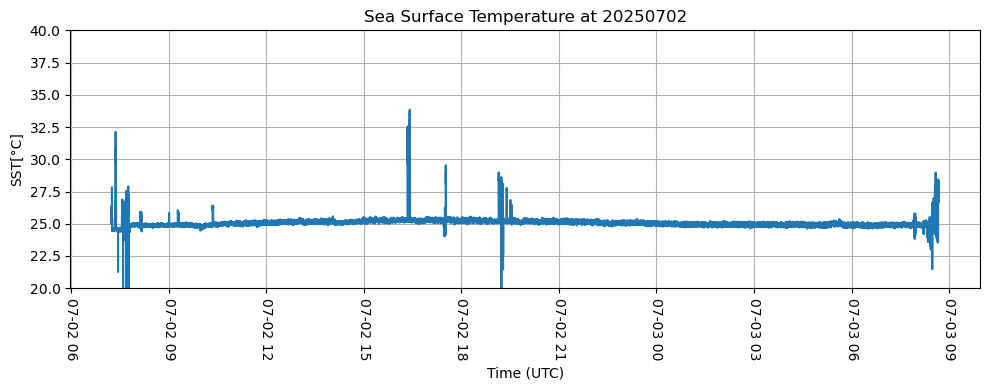

In [35]:
# === Plot ===
plt.figure(figsize=(10, 4))
plt.plot(df_sst["Time"], df_sst["SST (°C)"], label="SST")

plt.xlabel("Time (UTC)")
plt.ylabel("SST[°C]")

plt.ylim(20, 40)

plt.xticks(rotation=-90)
plt.title(f"Sea Surface Temperature at {date_str}")
plt.grid(True) 
#plt.legend()
plt.tight_layout()

plt.show()

### Calculate averages

In [189]:
# -- Calculate 1 min averages --
df_sst_avg = df_sst.copy() # Copy SST dataset

df_sst_avg = df_sst_avg.set_index("Time") # Set Time as index for resampling 

df_sst_avg = df_sst_avg.resample("1min").mean() # Average over 1 minute intervals

# OPTIONAL: save 1 min averages to CSV to the right folder
df_sst_avg.to_csv(sst_avg_file)

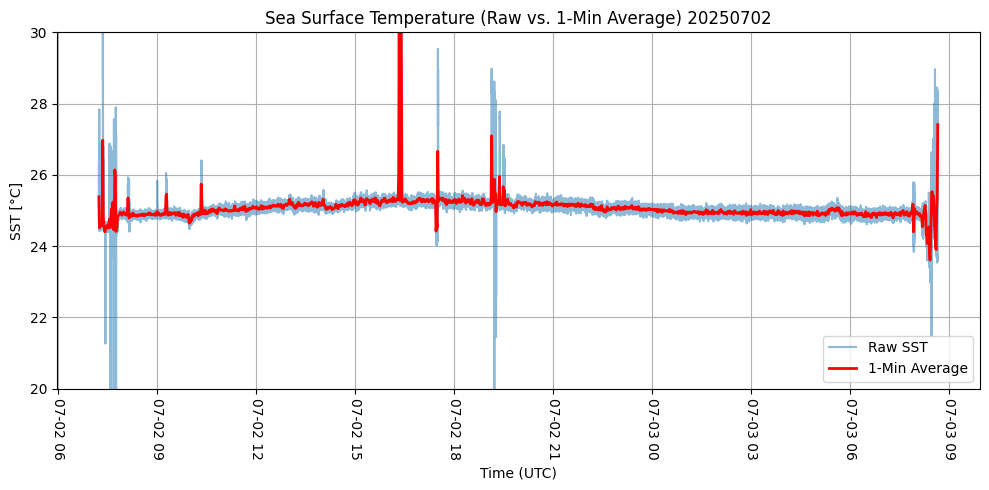

In [190]:
# PLOT
plt.figure(figsize=(10, 5))
plt.plot(df_sst["Time"], df_sst["SST (°C)"], label="Raw SST", alpha=0.5)
plt.plot(df_sst_avg.index, df_sst_avg["SST (°C)"], label="1-Min Average", linewidth=2, color='red')

plt.xlabel("Time (UTC)")
plt.ylabel("SST [°C]")
plt.title(f"Sea Surface Temperature (Raw vs. 1-Min Average) {date_str}")
plt.xticks(rotation=-90)

plt.ylim(20, 30)


plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Subset

In [183]:
# === Option A: Subset for a specific date ===
date = pd.to_datetime("2025-07-02").date() # Select date for subsetting
subset = df_sst[df_sst["Time"].dt.date == date] # Subset for the specific date

In [184]:
# == Option B: Subset for a specific time range ===
start_time = pd.to_datetime("2025-07-02 9:30:00")
end_time = pd.to_datetime("2025-07-02 9:40:00")
subset = df_sst[(df_sst["Time"] >= start_time) & (df_sst["Time"] <= end_time)]


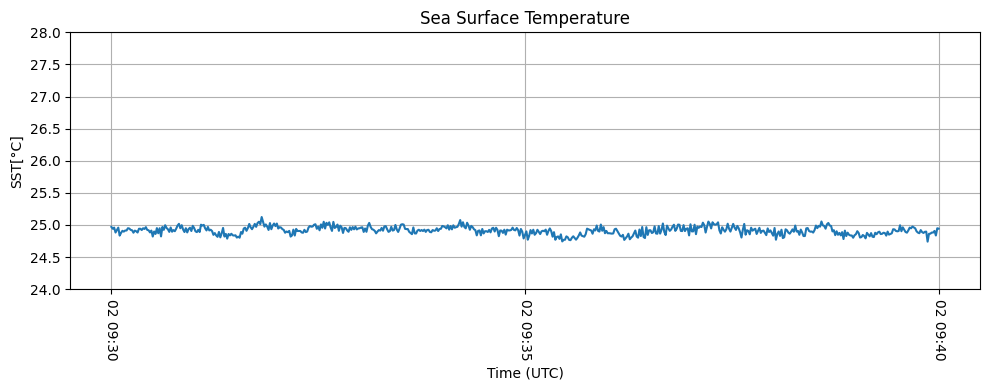

In [187]:
# === Plot ===
plt.figure(figsize=(10, 4))
plt.plot(subset["Time"], subset["SST (°C)"], label="SST")

plt.xlabel("Time (UTC)")
plt.ylabel("SST[°C]")

plt.ylim(24, 28)

plt.xticks(rotation=-90)
plt.title("Sea Surface Temperature")
plt.grid(True) 
#plt.legend()
plt.tight_layout()

plt.show()

### Find peak anomalies

In [138]:
# == Find values above a defined temperature threshold ==
df_sst_peaks = df_sst.copy()

threshold_K = 25  # Set threshold in Celsius

df_sst_peaks["anomaly"] = df_sst_peaks["SST (°C)"] > threshold_K

In [139]:
# == Identify anomalous events == 

df_sst_peaks = df_sst_peaks.sort_values("Time").reset_index(drop=True) # Make sure the dataset is sorted

# Create a block ID that increases only when anomaly status changes
df_sst_peaks["anomaly_block"] = (df_sst_peaks["anomaly"] != df_sst_peaks["anomaly"].shift()).cumsum()

anomaly_events = []

for block_id, group in df_sst_peaks.groupby("anomaly_block"):
    if group["anomaly"].iloc[0]:  # only keep anomaly blocks
        start_time = group["Time"].iloc[0]
        end_time   = group["Time"].iloc[-1]
        peak_temp  = group["SST (°C)"].max()
        anomaly_events.append({
            "Start": start_time,
            "End": end_time,
            "Duration [s]": (end_time - start_time).total_seconds(),
            "Max SST [°C]": peak_temp
        })

df_anomaly_events = pd.DataFrame(anomaly_events)
#print(df_anomaly_events)


In [140]:
# == Filter out anomaly events longer than a predefined duration
min_duration = 10 # seconds
df_anomaly_events_filtered = df_anomaly_events[df_anomaly_events["Duration [s]"] >= min_duration].reset_index(drop=True)
print(df_anomaly_events_filtered)


                 Start                 End  Duration [s]  Max SST [°C]
0  2025-06-29 06:58:33 2025-06-29 06:59:27          54.0     33.831502
1  2025-06-29 07:04:19 2025-06-29 07:04:34          15.0     25.652917
2  2025-06-29 13:09:55 2025-06-29 13:13:56         241.0     32.613139
3  2025-06-29 14:13:33 2025-06-29 14:14:00          27.0     27.992353
4  2025-06-29 14:32:41 2025-06-29 14:35:20         159.0     30.319747
5  2025-06-29 18:38:49 2025-06-29 18:39:07          18.0     28.731156
6  2025-06-29 18:40:04 2025-06-29 18:47:24         440.0     28.450716
7  2025-06-30 08:53:04 2025-06-30 08:53:17          13.0     25.453685
8  2025-06-30 08:53:20 2025-06-30 08:53:37          17.0     25.521801
9  2025-06-30 09:22:18 2025-06-30 09:23:08          50.0     25.751873
10 2025-06-30 09:24:40 2025-06-30 09:29:19         279.0     27.382270
11 2025-06-30 09:29:22 2025-06-30 09:29:37          15.0     25.088995
12 2025-06-30 09:34:25 2025-06-30 09:35:32          67.0     29.287893
13 202